## **Problem Statement:Stock Price Prediction using LSTMs**

In financial markets, accurately predicting stock prices is a challenging yet crucial task for investors, analysts, and traders. Leveraging historical stock prices, this project aims to develop models that can forecast future closing prices using advanced deep learning techniques like Long Short-Term Memory (LSTM) network. The goal is to compare the performance of LSTM and GRU models in predicting stock prices and evaluate their accuracy on unseen data.

In [ ]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

In [3]:
# Suppress warnings for clean output
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Problem Statement
print("Problem Statement: Predict future stock prices using time series data with LSTM and GRU models.")

# Data Description
print("\nData Description:")
print("We are using a stock prices dataset containing 'Date' and 'Close' columns.")
print("Objective: Predict the closing price for the next day based on historical data.")

# Step 1: Load the Data
# Load the dataset and parse the 'Date' column as a datetime object
df = pd.read_csv('stock_prices.csv', parse_dates=['Date'], index_col='Date')
df = df[['Close']]  # Using only the 'Close' column for forecasting
print("\nFirst 5 rows of the dataset:")
df.head()

Problem Statement: Predict future stock prices using time series data with LSTM and GRU models.

Data Description:
We are using a stock prices dataset containing 'Date' and 'Close' columns.
Objective: Predict the closing price for the next day based on historical data.

First 5 rows of the dataset:


,Close
Date,
2012-01-03,663.59
2012-01-04,666.45
2012-01-05,657.21
2012-01-06,648.24
2012-01-09,620.76


In [7]:
df['Close']=df['Close'].str.replace(",","").astype(float)

In [8]:
# Step 2: Data Preprocessing
# Checking for missing values
print("\nChecking for missing values...")
print(df.isnull().sum())


Checking for missing values...
Close    0
dtype: int64


In [9]:
# Scaling the data between 0 and 1 for better model performance
scaler = MinMaxScaler(feature_range=(0, 1))
df['Close'] = scaler.fit_transform(df[['Close']])

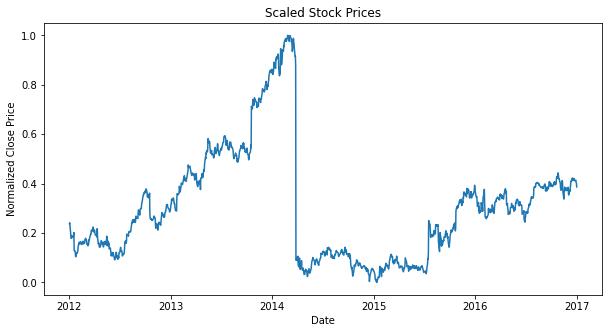

In [10]:
# Visualizing the scaled data
plt.figure(figsize=(10, 5))
plt.plot(df['Close'])
plt.title('Scaled Stock Prices')
plt.xlabel('Date')
plt.ylabel('Normalized Close Price')
plt.show()

In [11]:
# Step 3: Prepare the Data for Time Series Forecasting
# Function to create sequences of data for model training
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Convert the dataframe to a numpy array
data = df.values

In [12]:
# Split data into training (80%) and testing sets (20%)
train_size = int(len(data) * 0.8)
test_size = len(data) - train_size
train_data, test_data = data[:train_size], data[train_size:]

In [13]:
# Create the training and testing datasets using a time step of 60
time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape data to fit the input format expected by LSTM/GRU models (samples, time_steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [14]:
# Step 4: LSTM Model Implementation
print("\nBuilding and Training the LSTM Model...")

# Define the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(64, return_sequences=True, input_shape=(time_step, 1)))
lstm_model.add(Dropout(0.2))  # Dropout to prevent overfitting
lstm_model.add(LSTM(32))
lstm_model.add(Dense(1))  # Output layer with one neuron for prediction
lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Train the LSTM model
history_lstm = lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)


Building and Training the LSTM Model...
Epoch 1/20
30/30 [==============================] - 5s 66ms/step - loss: 0.0239 - val_loss: 8.2901e-04
Epoch 2/20
30/30 [==============================] - 1s 40ms/step - loss: 0.0059 - val_loss: 7.6427e-04
Epoch 3/20
30/30 [==============================] - 1s 41ms/step - loss: 0.0047 - val_loss: 6.6138e-04
Epoch 4/20
30/30 [==============================] - 1s 41ms/step - loss: 0.0042 - val_loss: 5.7234e-04
Epoch 5/20
30/30 [==============================] - 1s 39ms/step - loss: 0.0044 - val_loss: 0.0011
Epoch 6/20
30/30 [==============================] - 1s 40ms/step - loss: 0.0039 - val_loss: 0.0013
Epoch 7/20
30/30 [==============================] - 1s 39ms/step - loss: 0.0033 - val_loss: 9.2423e-04
Epoch 8/20
30/30 [==============================] - 1s 40ms/step - loss: 0.0031 - val_loss: 5.8423e-04
Epoch 9/20
30/30 [==============================] - 2s 74ms/step - loss: 0.0033 - val_loss: 4.4437e-04
Epoch 10/20
30/30 [=====================

In [17]:
# Step 6: Model Evaluation

# Function to evaluate and plot the model's performance
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    # Make predictions on training and testing data
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

    # Inverse transform predictions to original scale
    train_pred = scaler.inverse_transform(train_pred)
    test_pred = scaler.inverse_transform(test_pred)
    y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Calculate evaluation metrics: RMSE and MAE
    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
    train_mae = mean_absolute_error(y_train, train_pred)
    test_mae = mean_absolute_error(y_test, test_pred)

    print(f"\n{model_name} - Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")
    print(f"{model_name} - Train MAE: {train_mae:.4f}, Test MAE: {test_mae:.4f}")

    # Plotting actual vs predicted values
    plt.figure(figsize=(12, 5))
    plt.plot(y_test, label='Actual')
    plt.plot(test_pred, label=f'{model_name} Predictions')
    plt.title(f'{model_name} Predictions vs Actual')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()


Evaluating LSTM Model...
6/6 [==============================] - 0s 16ms/step

LSTM - Train RMSE: 33.3269, Test RMSE: 19.2183
LSTM - Train MAE: 16.4586, Test MAE: 15.5040


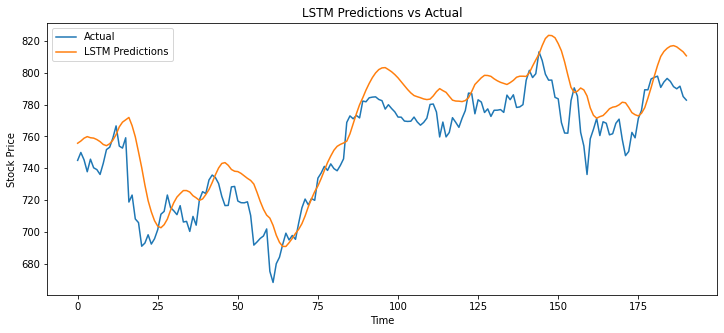


Evaluating GRU Model...
6/6 [==============================] - 0s 13ms/step

GRU - Train RMSE: 25.2723, Test RMSE: 13.2692
GRU - Train MAE: 11.2356, Test MAE: 10.6814


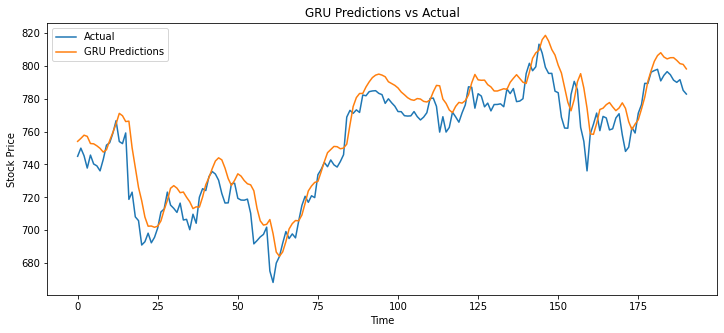

In [ ]:
# Evaluate the LSTM Model
print("\nEvaluating LSTM Model...")
evaluate_model(lstm_model, X_train, y_train, X_test, y_test, "LSTM")
